## Depth integrated tracer on shelf per km along shelf
New runs have correct bottom boundary conditions (free slip + drag) and an advective tracer. Looking ofr differences between runs with different body forcing.

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt


In [2]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [3]:
# plotting functions
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')


In [31]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)
Ptracers37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run62/ptracersGlob.nc' 
Ptracers36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run63/ptracersGlob.nc' 
Ptracers43 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run61/ptracersGlob.nc' 

PtracersU32 = '/ocean/kramosmu/MITgcm/TracerExperiments/LOWER_BF/run01/ptracersGlob.nc' 
PtracersU26 = '/ocean/kramosmu/MITgcm/TracerExperiments/LOW_BF/run01/ptracersGlob.nc' 
PtracersU32NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/LOWER_BF/run02/ptracersGlob.nc' 
PtracersU26NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/LOW_BF/run02/ptracersGlob.nc' 

Ptracers043D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc' 
Ptracers053D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc' 
Ptracers063D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc' 
Ptracers073D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/ptracersGlob.nc' 

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)

State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 




In [33]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [34]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [7]:
Tr1 = rout.getField(Ptracers, 'Tr1')

Tr1NoC = rout.getField(PtracersNoC, 'Tr1')



## Changing Diffusivity

In [9]:
HCW,TrMass = HCW_Tracer_AlongShelf(Tr1,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWNoC,TrMassNoC = HCW_Tracer_AlongShelf(Tr1NoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)



tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


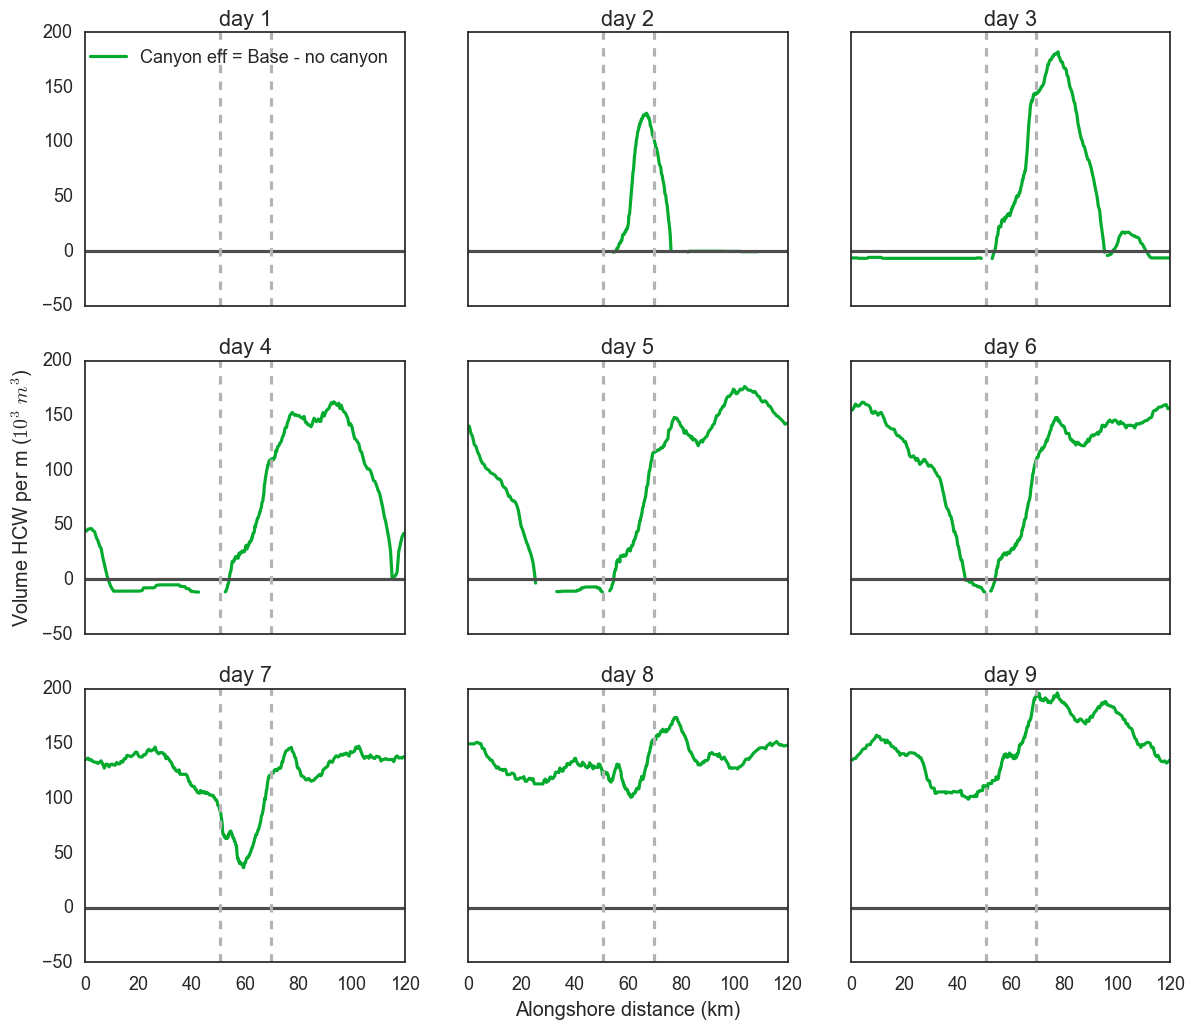

In [10]:
   

fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    
    ax.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Canyon eff = Base - no canyon')
    #ax.plot(xc[1,:]/1000,HCWNoC[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["battleship grey"],label='No canyon')
    ax.axhline(0,color='0.3')
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')

    


In [35]:
Tra = rout.getField(Ptracers37, 'Tr1')
Trb = rout.getField(Ptracers36, 'Tr1')
Trc = rout.getField(Ptracers43, 'Tr1')


In [36]:
HCW37,TrMass37 = HCW_Tracer_AlongShelf(Tra,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCW36,TrMass36 = HCW_Tracer_AlongShelf(Trb,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCW43,TrMass43 = HCW_Tracer_AlongShelf(Trc,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


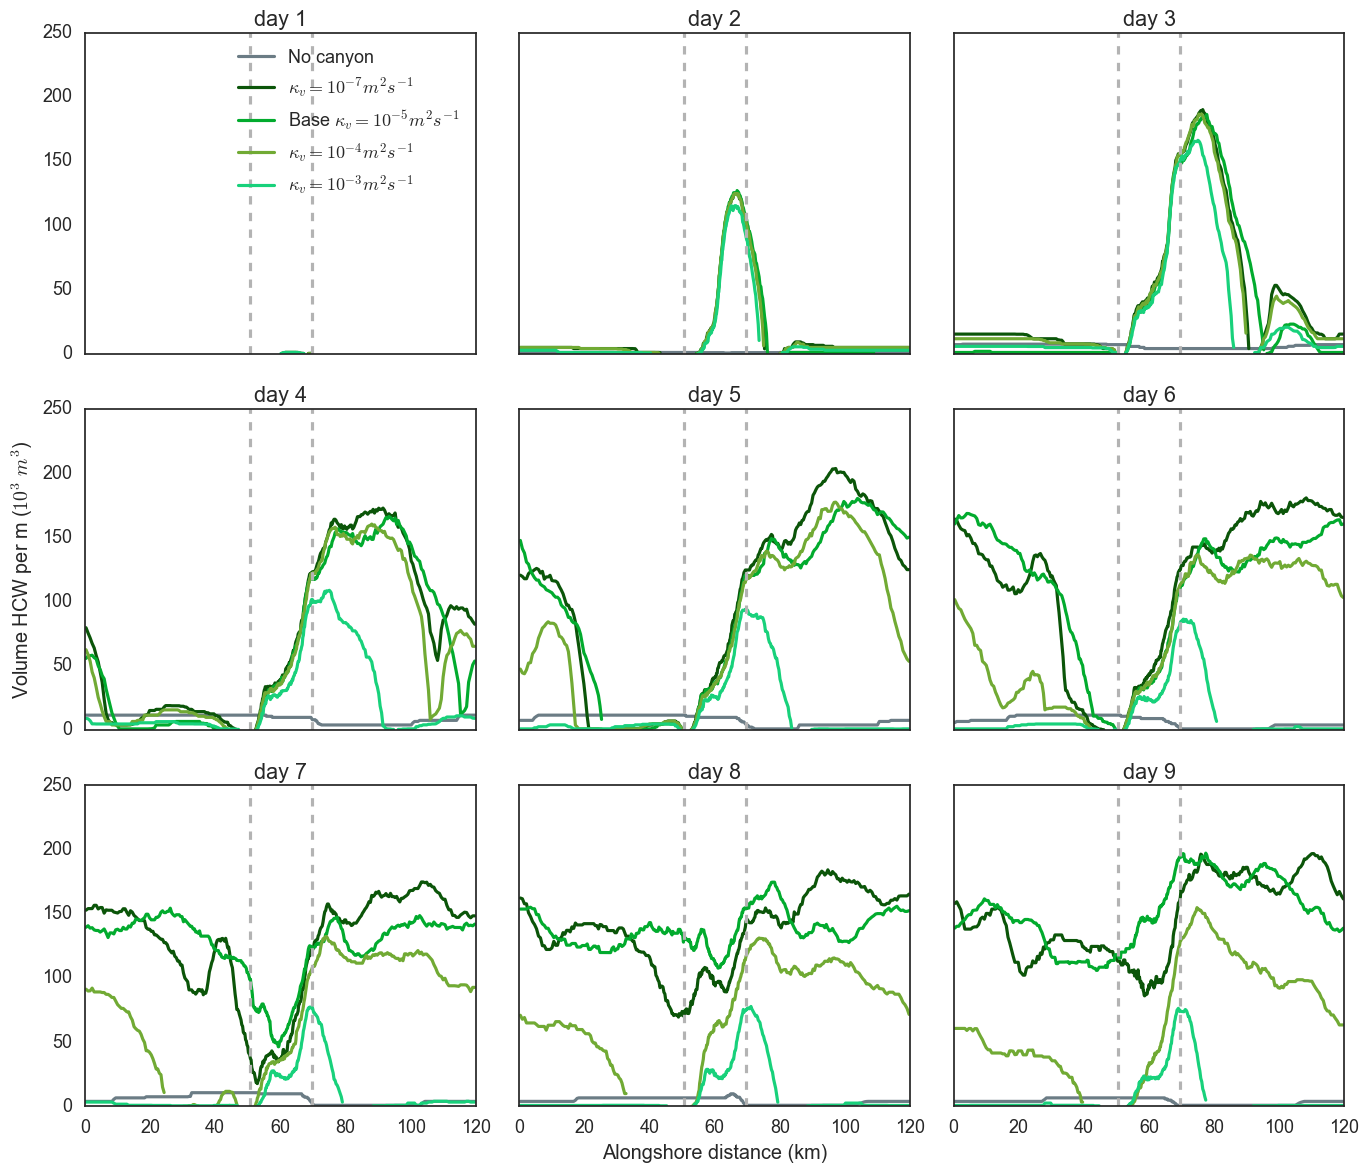

In [37]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,HCWNoC[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["battleship grey"],label='No canyon')
    ax.plot(xc[1,:]/1000,HCW43[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["forest"],label='$\kappa_v=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW37[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW36[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')

    
plt.tight_layout()

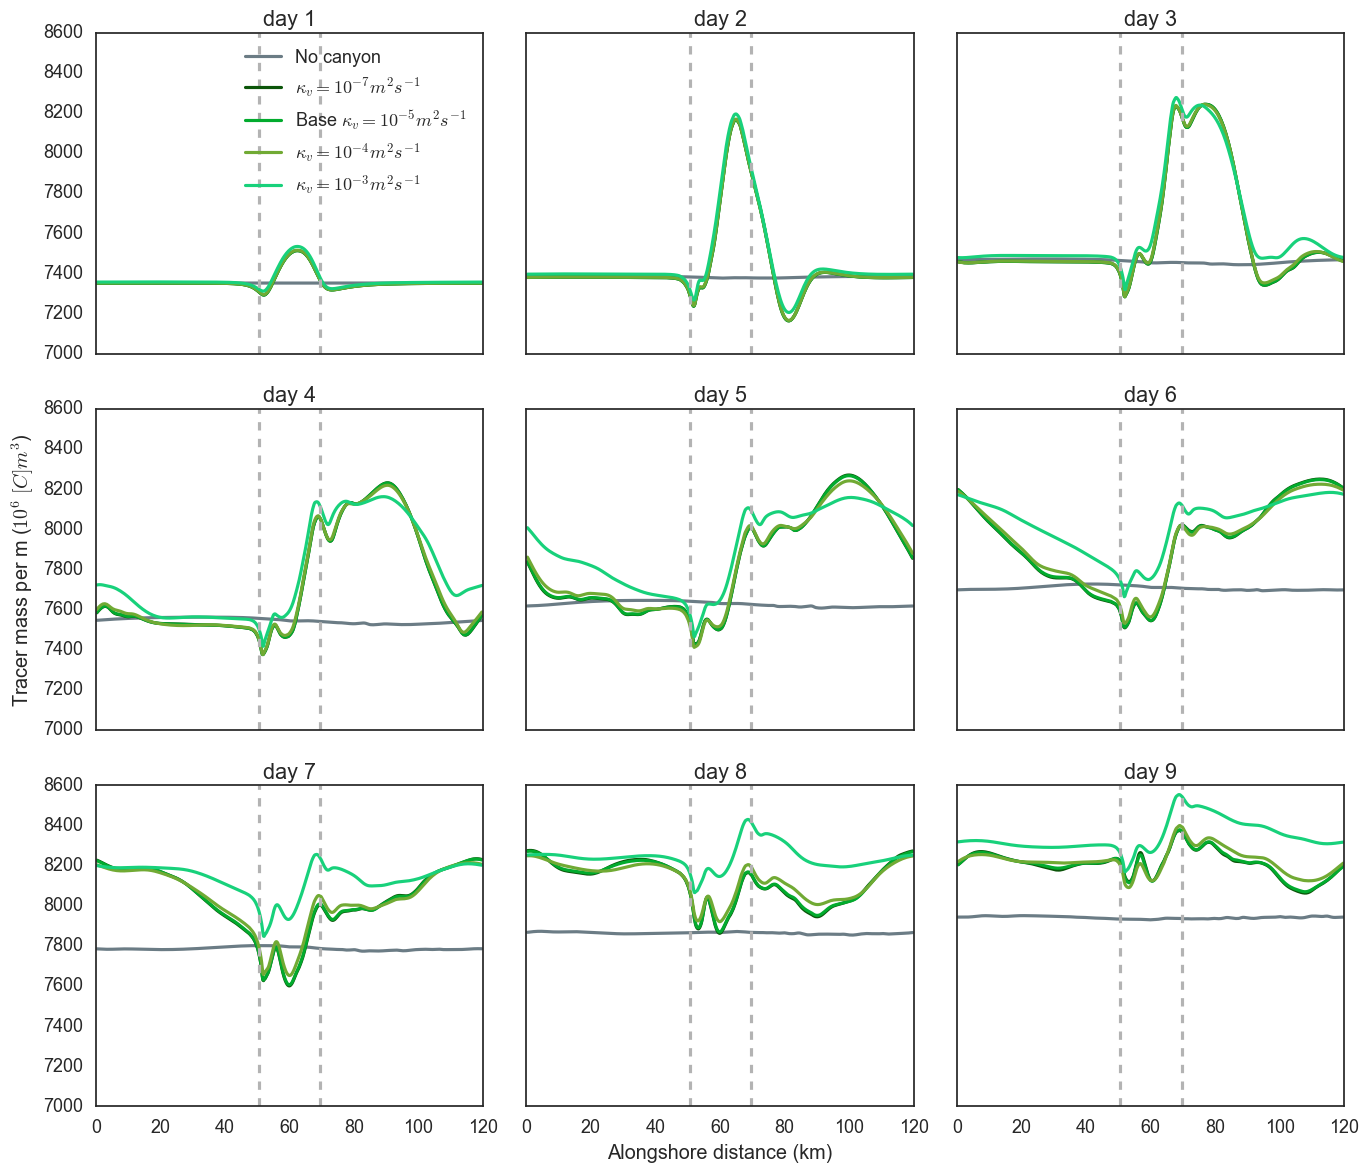

In [14]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,TrMassNoC[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["battleship grey"],label='No canyon')
    ax.plot(xc[1,:]/1000,TrMass43[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["forest"],label='$\kappa_v=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass37[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass36[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')

plt.tight_layout()    
#fig.savefig('/home/kramosmu/Documents/CommitteeMeeting2016/Figures/TracerMassAlong_KvVariation.pdf', format='pdf', dpi=1000, bbox_inches='tight')


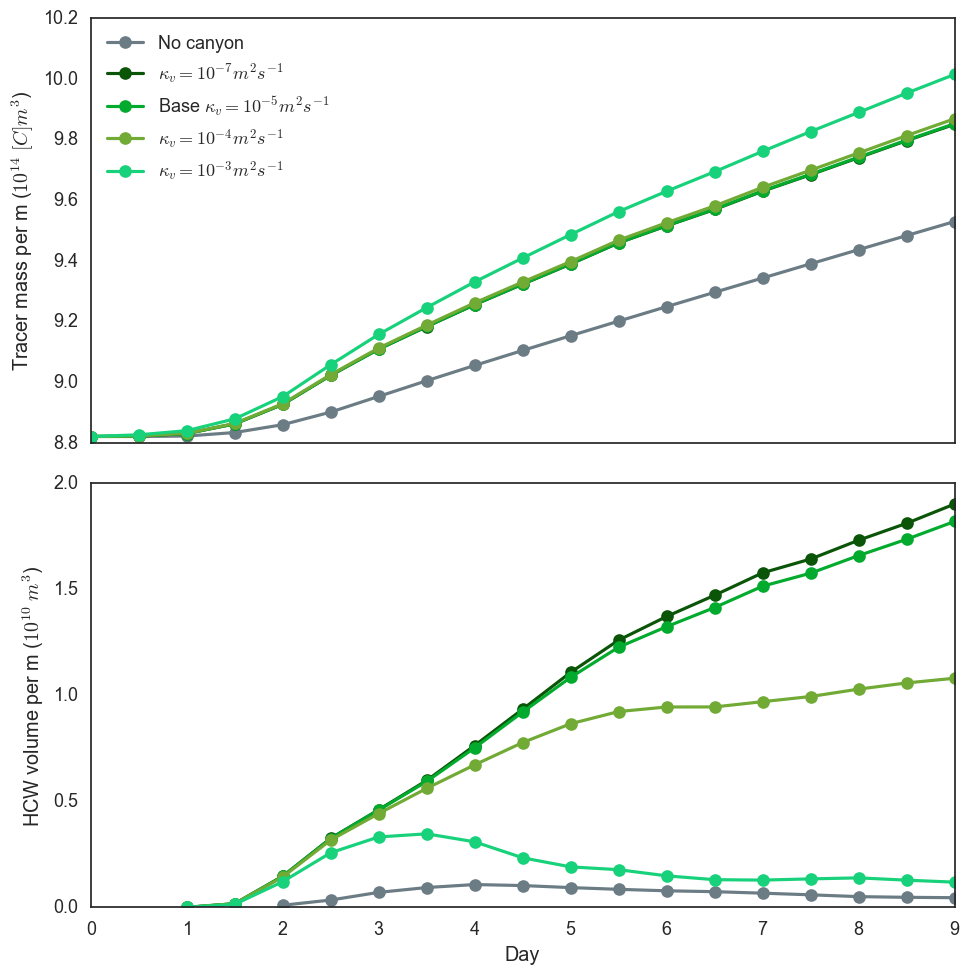

In [15]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMassNoC,axis=1)/1.E14,sns.xkcd_rgb["battleship grey"],marker = 'o',label='No canyon')
ax1.plot(tt/2.,np.sum(TrMass43,axis=1)/1.E14,sns.xkcd_rgb["forest"],marker = 'o',label='$\kappa_v=10^{-7}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass37,axis=1)/1.E14,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass36,axis=1)/1.E14,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCWNoC,axis=1)/1.E10,sns.xkcd_rgb["battleship grey"],marker = 'o',label='No canyon')
ax2.plot(tt/2.,np.sum(HCW43,axis=1)/1.E10,sns.xkcd_rgb["forest"],marker = 'o',label='$\kappa_v=10^{-7}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW37,axis=1)/1.E10,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW36,axis=1)/1.E10,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
  
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
plt.tight_layout()

plt.show()



## Changing geography of diapycnal diffusivity 

In [16]:
Tra = rout.getField(Ptracers043D, 'Tr1')
Trb = rout.getField(Ptracers053D, 'Tr1')
Trc = rout.getField(Ptracers063D, 'Tr1')
Trd = rout.getField(Ptracers073D, 'Tr1')

In [17]:
HCW043D,TrMass043D = HCW_Tracer_AlongShelf(Tra,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCW053D,TrMass053D = HCW_Tracer_AlongShelf(Trb,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCW063D,TrMass063D = HCW_Tracer_AlongShelf(Trc,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCW073D,TrMass073D = HCW_Tracer_AlongShelf(Trd,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


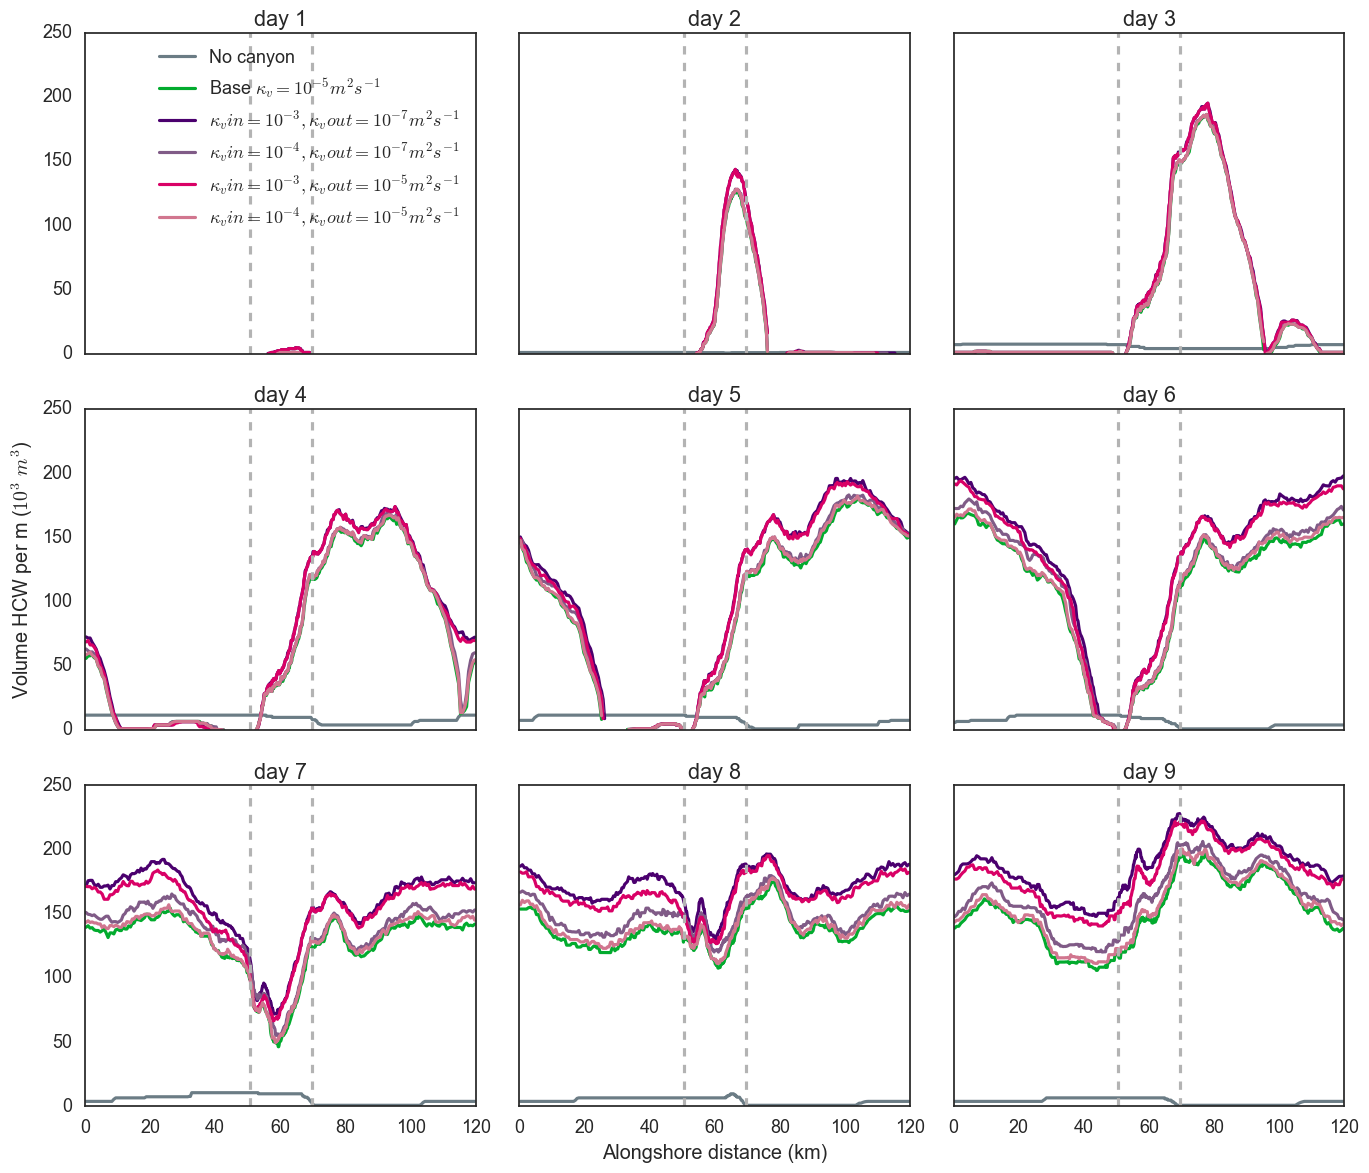

In [18]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,HCWNoC[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["battleship grey"],label='No canyon')
    ax.plot(xc[1,:]/1000,HCW[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW043D[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["royal purple"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW053D[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["muted purple"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW063D[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,HCW073D[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')

plt.tight_layout()    


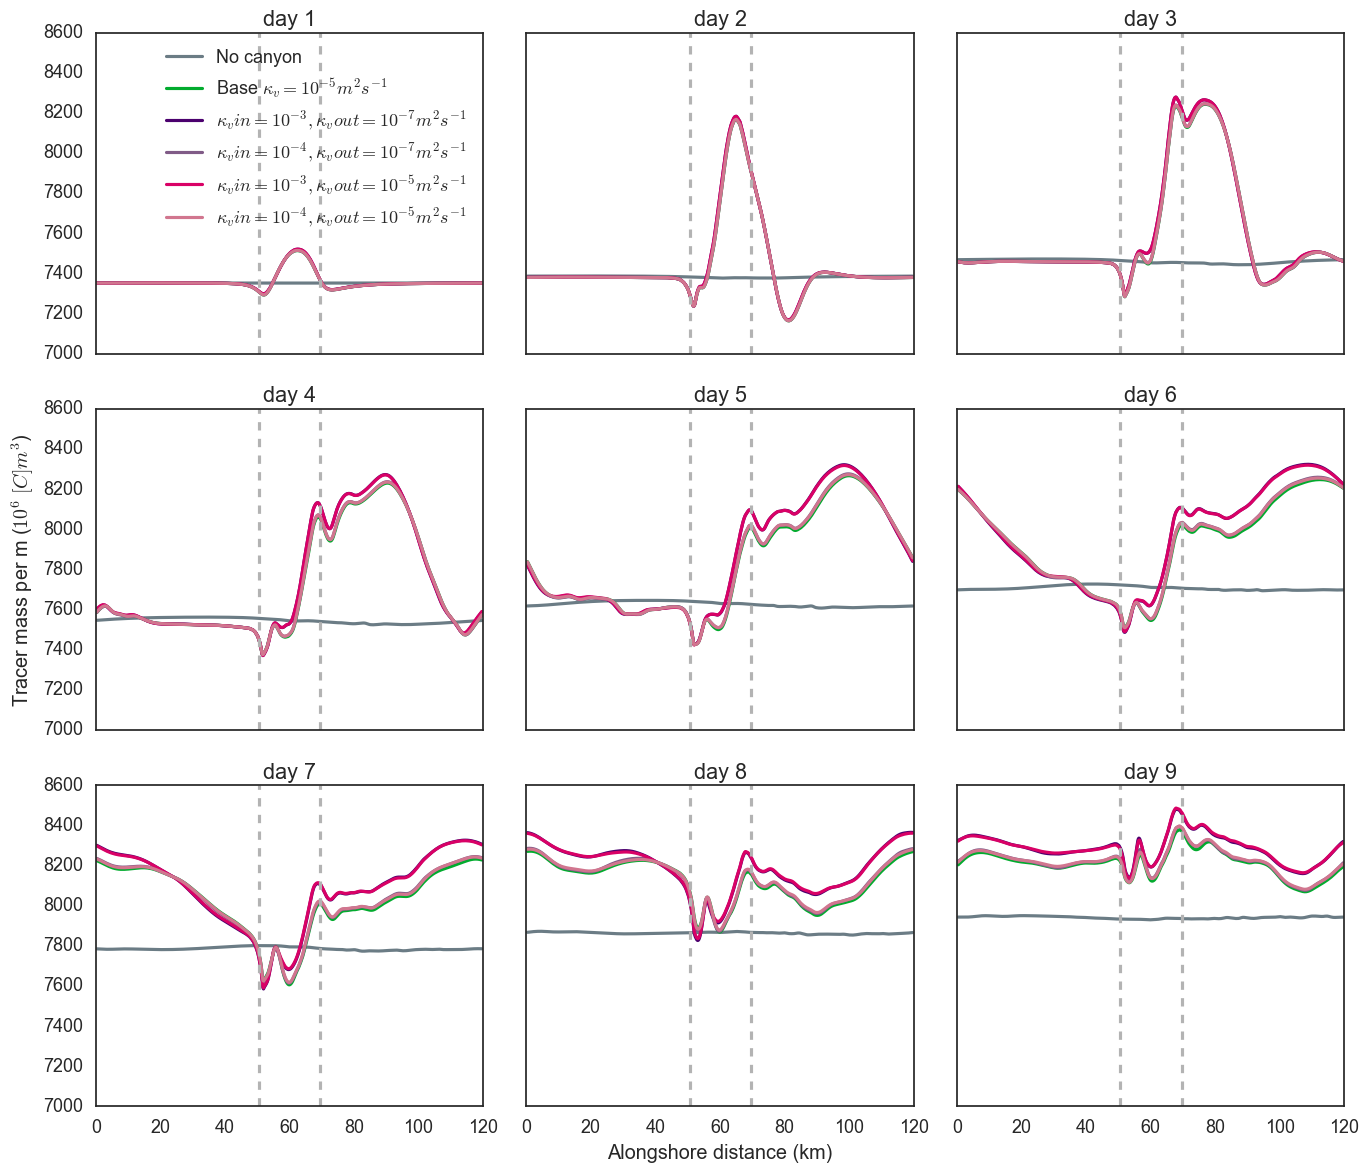

In [19]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,TrMassNoC[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["battleship grey"],label='No canyon')
    ax.plot(xc[1,:]/1000,TrMass[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass043D[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["royal purple"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass053D[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["muted purple"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-7}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass063D[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,TrMass073D[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')

#fig.savefig('/home/kramosmu/Documents/CommitteeMeeting2016/Figures/TracerMassAlong_EnhancedKv.pdf', format='pdf', dpi=1000, bbox_inches='tight')

plt.tight_layout()

In [20]:
-

SyntaxError: invalid syntax (<ipython-input-20-0a1f21a34173>, line 1)

## Changing body forcing

In [21]:
Tra = rout.getField(PtracersU32, 'Tr1')
Trb = rout.getField(PtracersU26, 'Tr1')


In [22]:
HCWU32,TrMassU32 = HCW_Tracer_AlongShelf(Tra,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWU26,TrMassU26 = HCW_Tracer_AlongShelf(Trb,mask_NoC,30,rA,hFacC,drF,227,30,180,50)


tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


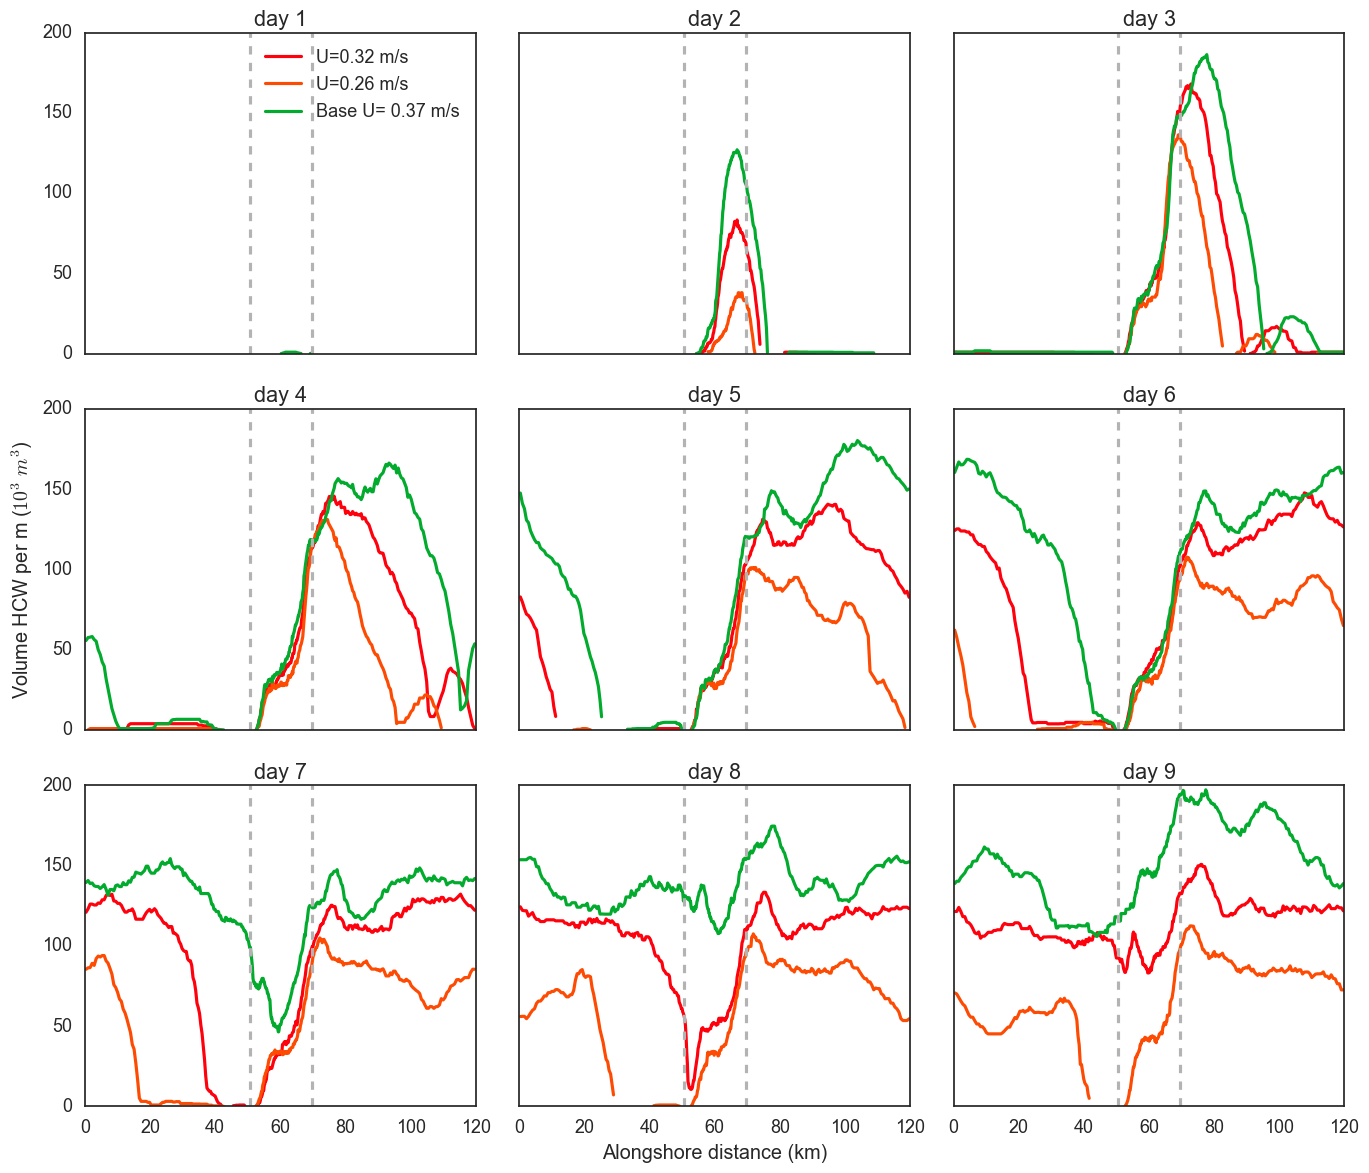

In [23]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    
    ax.plot(xc[1,:]/1000,HCWU32[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
    ax.plot(xc[1,:]/1000,HCWU26[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
    ax.plot(xc[1,:]/1000,HCW[ii,:]/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base U= 0.37 m/s')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
plt.tight_layout()


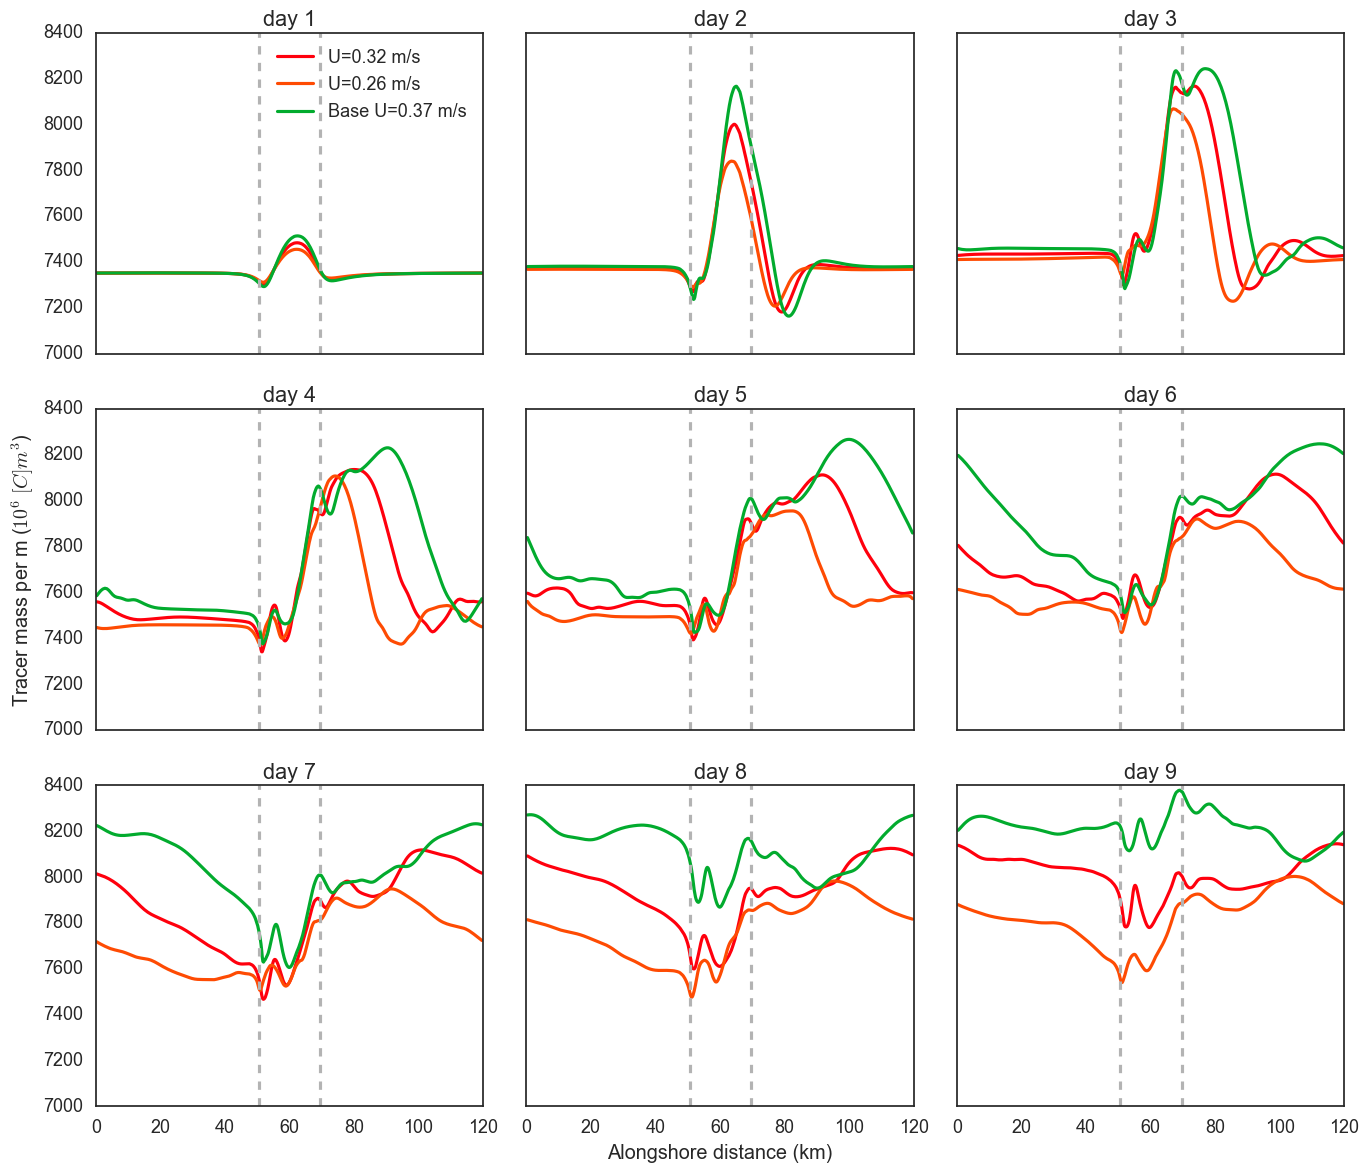

In [24]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,TrMassU32[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
    ax.plot(xc[1,:]/1000,TrMassU26[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
    ax.plot(xc[1,:]/1000,TrMass[ii,:]/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base U=0.37 m/s')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')

plt.tight_layout()

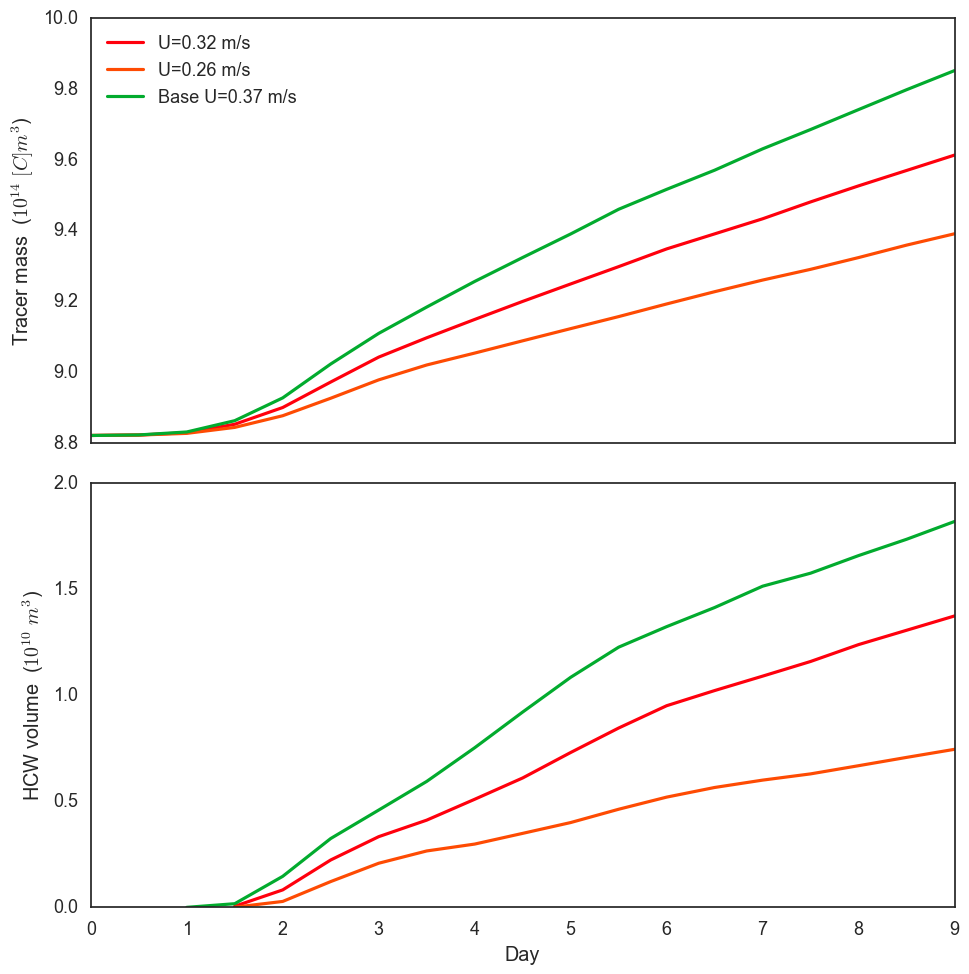

In [25]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMassU32 ,axis=1)/1.E14,sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
ax1.plot(tt/2.,np.sum(TrMassU26 ,axis=1)/1.E14,sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
ax1.plot(tt/2.,np.sum(TrMass ,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],label='Base U=0.37 m/s')
   
ax2.plot(tt/2.,np.sum(HCWU32 ,axis=1)/1.E10,sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
ax2.plot(tt/2.,np.sum(HCWU26 ,axis=1)/1.E10,sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
ax2.plot(tt/2.,np.sum(HCW ,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],label='Base U=0.37 m/s')
     
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass  ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume  ($10^{10}$ $m^3$)')
plt.tight_layout()
plt.show()



In [27]:
TraNoC = rout.getField(PtracersU32NoC, 'Tr1')
TrbNoC = rout.getField(PtracersU26NoC, 'Tr1')


In [28]:
HCWU32NoC,TrMassU32NoC = HCW_Tracer_AlongShelf(TraNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)
HCWU26NoC,TrMassU26NoC = HCW_Tracer_AlongShelf(TrbNoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)


tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


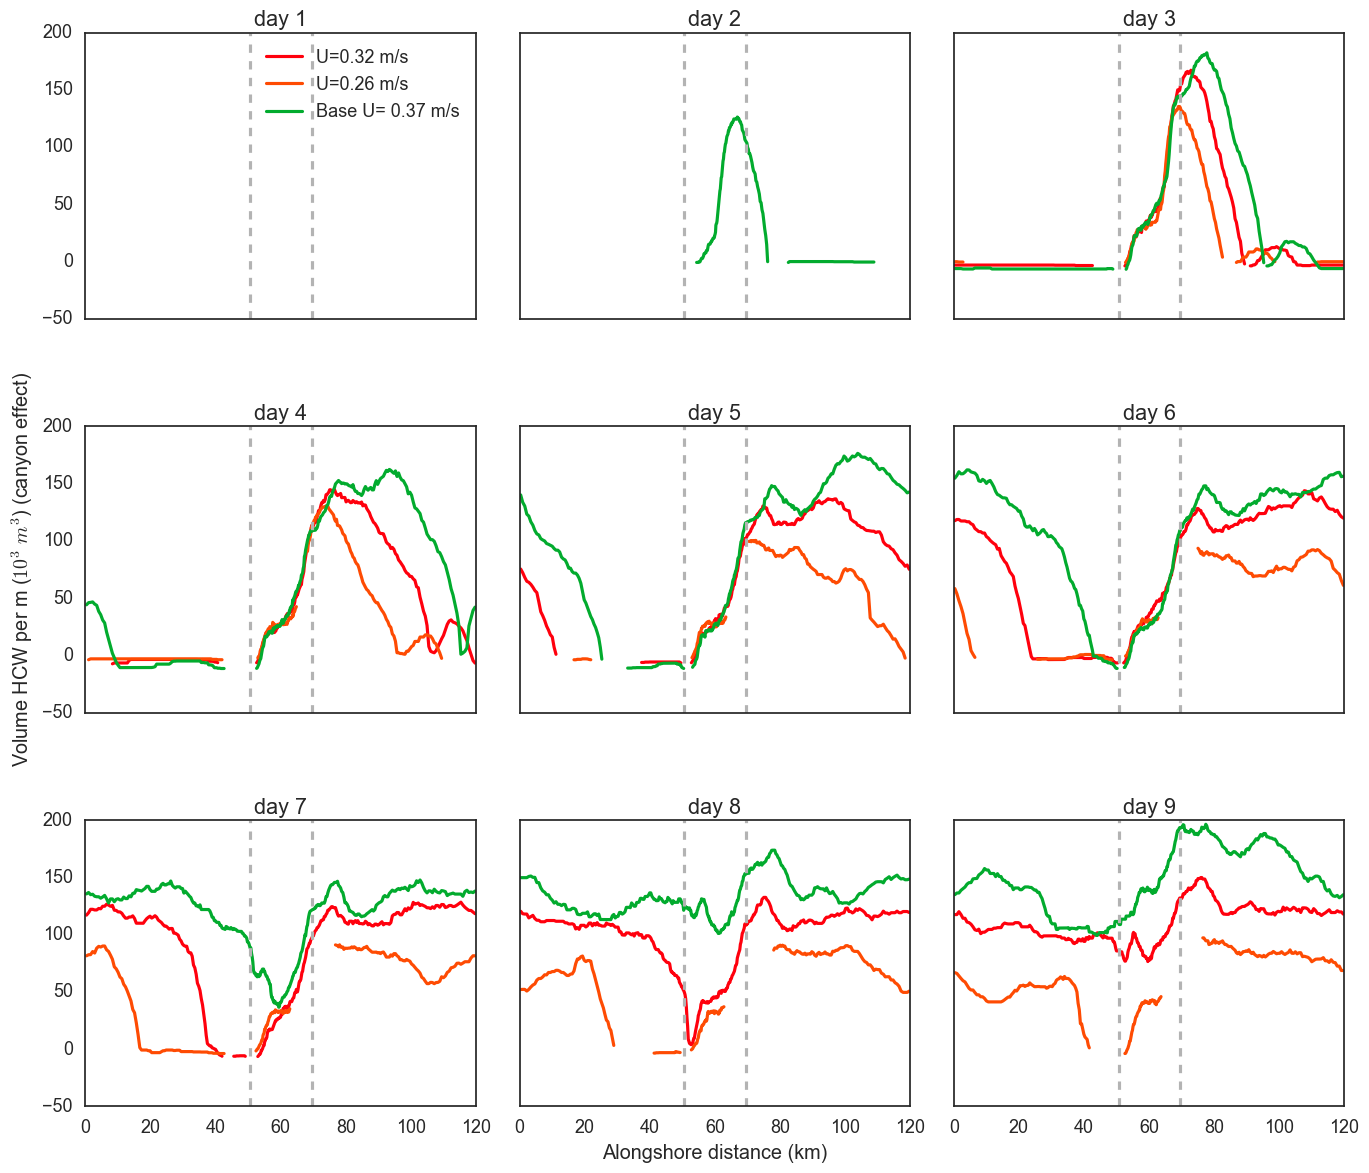

In [29]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    
    ax.plot(xc[1,:]/1000,(HCWU32[ii,:]-HCWU32NoC[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
    ax.plot(xc[1,:]/1000,(HCWU26[ii,:]-HCWU26NoC[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
    ax.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base U= 0.37 m/s')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$) (canyon effect)')
plt.tight_layout()


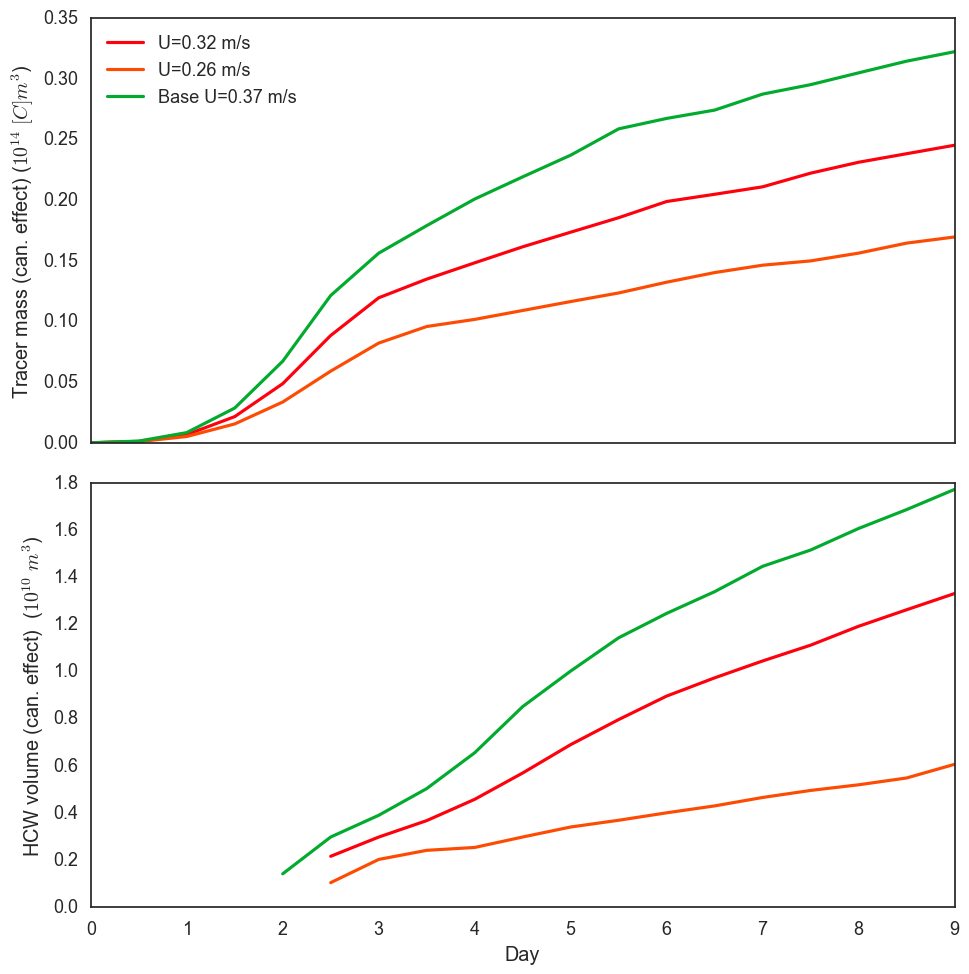

In [30]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMassU32-TrMassU32NoC ,axis=1)/1.E14,sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
ax1.plot(tt/2.,np.sum(TrMassU26-TrMassU26NoC ,axis=1)/1.E14,sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
ax1.plot(tt/2.,np.sum(TrMass-TrMassNoC ,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],label='Base U=0.37 m/s')
   
ax2.plot(tt/2.,np.sum(HCWU32-HCWU32NoC ,axis=1)/1.E10,sns.xkcd_rgb["bright red"],label='U=0.32 m/s')
ax2.plot(tt/2.,np.sum(HCWU26-HCWU26NoC ,axis=1)/1.E10,sns.xkcd_rgb["blood orange"],label='U=0.26 m/s')
ax2.plot(tt/2.,np.sum(HCW-HCWNoC ,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],label='Base U=0.37 m/s')
     
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass (can. effect) ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume (can. effect)  ($10^{10}$ $m^3$)')
plt.tight_layout()
plt.show()

